In [12]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.preprocessing import image
from keras.models import Model

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
import cv2
import os

from UNet_model import build_unet


In [3]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

(480, 640, 3)
2.0
[0. 1. 2.]


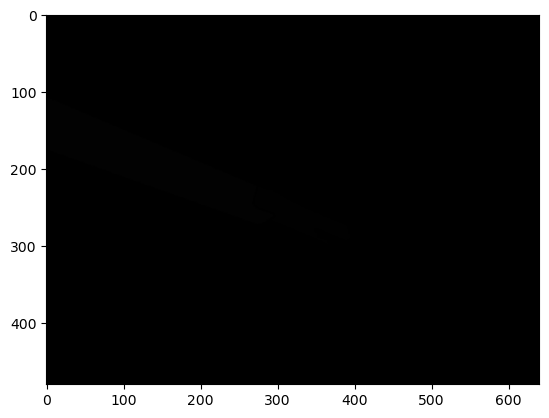

In [63]:
# pic = load_img('./dataset/train/graymasks_augmented/aug__0_1011.png')
pic = load_img('./dataset/train/graymasks_normalized_augmented/aug__102_1597.png', cv2.IMREAD_COLOR)
# pic.getpixel
pic_array = img_to_array(pic)
# pic_array = pic_array
print(pic_array.shape)
print(np.max(pic_array))
print(np.unique(pic_array))
plt.imshow(pic)
# plt.imshow(pic_array)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.  80. 160.]
160.0


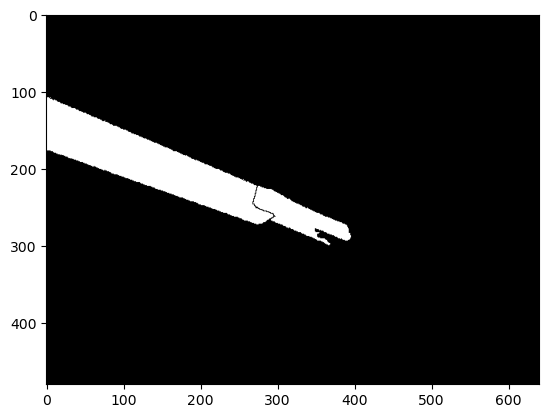

In [69]:
test_image = cv2.imread('./dataset/train/graymasks_normalized_augmented/aug__102_1597.png', cv2.IMREAD_COLOR)
test_image = test_image * (160/2)
print(np.unique(test_image))
print(np.max(test_image))

plt.imshow(test_image)

In [3]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [13]:
raw_ag_path = './dataset/train/raw_augmented'
graymask_ag_path = './dataset/train/graymasks_normalized_augmented/'
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")

create_dir(raw_ag_path)
create_dir(graymask_ag_path)

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [27]:
data_dir = sorted(glob(os.path.join('./dataset/train/raw/', '*.png')))
total_ds = []
for i, path in tqdm(enumerate(data_dir)):
    img = image.load_img(path, target_size=(640,480,3))
    img = image.img_to_array(img)
    img = img/255.0
    total_ds.append(img)

X = np.array(total_ds)
    
# print(X[0].shape, X[0])

data_dir = sorted(glob(os.path.join('./dataset/train/mask/', '*.png')))
total_ds = []
for i, path in tqdm(enumerate(data_dir)):
    img = image.load_img(path, target_size=(640,480,3))
    img = image.img_to_array(img)
    # img = img
    total_ds.append(img)

Y = np.array(total_ds)

print(np.expand_dims(X[0], axis=0).shape)


120it [00:00, 186.13it/s]
0it [00:00, ?it/s]

(1, 640, 480, 3)


In [25]:
count = 0
for batch in train_datagen.flow(np.expand_dims(X[0], axis=0), batch_size=2, save_to_dir='./dataset/train/raw_augmented'):
    count += 1
    if count == 10:
        break
print(f'images generated ({count})')




images generated (10)


In [26]:
v_count = 0
for batch in validation_datagen.flow(np.expand_dims(Y[0], axis=0), batch_size=2, save_to_dir='./dataset/train/graymasks_normalized_augmented/'):
    v_count += 1
    if v_count == 10:
        break
print(f'images generated ({v_count})')




images generated (10)


In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

validation_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

train_generator = train_datagen.flow_from_directory(
        './dataset/train/raw',
        target_size=(640,480),
        batch_size=4,
        class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
        './dataset/train/graymasks_normalized',
        target_size=(640,480),
        batch_size=4,
        class_mode='categorical'
)

model = build_unet(input_shape=(480,640,3), num_classes=3)
model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(1e-4)
    )

callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path, append=True),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=100,
        callbacks=callbacks
)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


2023-07-27 11:10:06.152204: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 11:10:06.434332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1002 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [11]:
data_dir = sorted(glob(os.path.join('./dataset/train/raw/', '*.png')))
total_ds = []
for i, path in tqdm(enumerate(data_dir)):
    img = image.load_img(path, target_size=(640,480,3))
    img = image.img_to_array(img)
    img = img/255.0
    total_ds.append(img)

X = np.array(total_ds)
    
print(X[0])
    

120it [00:00, 179.39it/s]


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[1. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
